Create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/ec2-user/geoseg/segment-anything/notebooks


## Load Model

In [2]:
import torch

DEVICE = torch.device('cuda')
MODEL_TYPE = "vit_b"

In [3]:
import torch
print(torch.cuda.is_available())

True


In [4]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-r8t4q7ue
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-r8t4q7ue
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

chkpt_path = '../weights/sam_vit_b_01ec64.pth'
sam = sam_model_registry[MODEL_TYPE](checkpoint=chkpt_path).to(device=DEVICE)

predictor = SamPredictor(sam)

In [6]:
import cv2
from PIL import Image

img = cv2.imread('../dataset/images/000.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
predictor.set_image(img)

In [8]:
import json
import torch

# place an image "img.png" and a json file "img.json" in the cd

# Read the JSON file
with open('../dataset/labels/000.json', 'r') as file:
    data = json.load(file)
    bboxes = data['bboxes']

# 20 boxes per bin
input_boxes_batches = []
curr_batch = []
count = 0
for bbox in bboxes:
    x, y, w, h = bbox
    count += 1
    if (count != 20):
        curr_batch.append([x, y, x+w, y+h])
    else:
        input_boxes_batches.append(curr_batch)
        curr_batch = []
        curr_batch.append([x, y, x+w, y+h])
        count = 1

In [9]:
import torch
import gc

In [10]:
masks_batches = []

for input_boxes in input_boxes_batches:
    tens_boxes = torch.tensor(input_boxes, device=predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(tens_boxes, img.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    masks_batches.append(masks)

    # Delete the tensors
    del tens_boxes
    # If you have other tensors or models on GPU, you should delete them as well

    # Empty the cache
    torch.cuda.empty_cache()

    # Run the garbage collector
    gc.collect()


In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [12]:
# plt.figure(figsize=(10, 10))
# plt.imshow(img)
# for masks in masks_batches:
#     for mask in masks:
#         show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
# plt.axis('off')
# plt.show()
# print(len(masks_batches))

In [13]:
result = []
for masks in masks_batches:
    for mask in masks:
        result.append(mask.cpu().numpy())

In [14]:
import numpy as np
import cv2

polygons = []

for j, res in enumerate(result):
    # Convert the boolean mask to a format suitable for OpenCV
    res = result[j]

    # Ensure the mask is a 2D array
    if res.ndim > 2:
        res = res.squeeze()  # Remove singleton dimensions

    # Check if the result is non-empty and 2D
    if res.ndim == 2 and res.size > 0:
        # Convert the boolean mask to a format suitable for OpenCV
        mask = (res.astype(np.uint8) * 255)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        polygons += [cv2.approxPolyDP(contour, 1, True).tolist() for contour in contours]
    else:
        print("Invalid mask shape or empty mask")


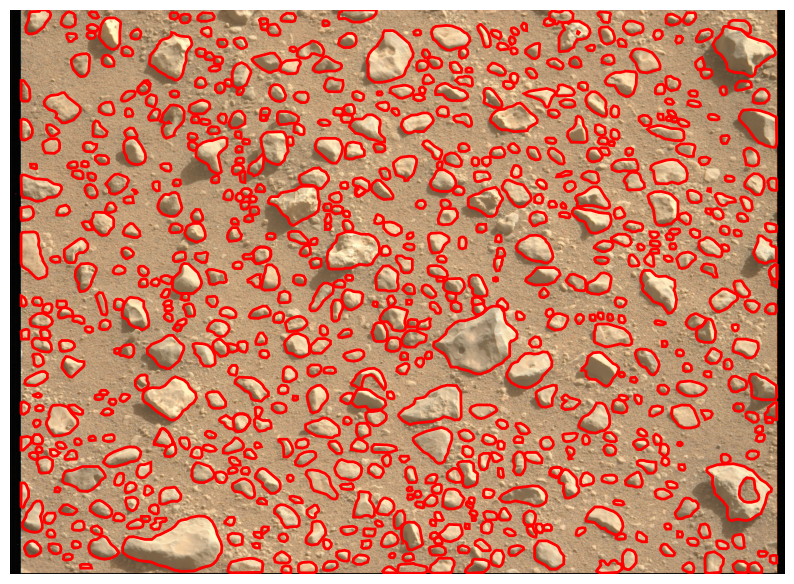

In [15]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

# Add the polygons to the plot
for poly in polygons:
    # Remove the extra level of nesting in the polygon points
    poly_np = np.array(poly).reshape(-1, 2)
    polygon_patch = Polygon(poly_np, edgecolor='red', fill=False, linewidth=2)
    ax.add_patch(polygon_patch)

# Remove axis ticks and labels
ax.axis('off')

# Show the plot
plt.show()


In [16]:
def polygon_area(polygon):
    """Calculate the area of a polygon using the shoelace formula."""
    n = len(polygon)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += polygon[i][0][0] * polygon[j][0][1]
        area -= polygon[j][0][0] * polygon[i][0][1]
    area = abs(area) / 2.0
    return area

# Example usage
polygon = [[[1408, 846]], [[1406, 858]], [[1409, 868]], [[1423, 885]], [[1433, 889]], [[1446, 889]], [[1457, 887]], [[1463, 884]], [[1465, 877]], [[1454, 850]], [[1445, 841]], [[1428, 840]]]
print("Polygon area:", polygon_area(polygon))

Polygon area: 2168.5


In [17]:
import numpy as np

def is_between(a, b, c):
    """Check if point c is between points a and b."""
    # Check if c is within the bounding box defined by a and b
    return min(a[0], b[0]) <= c[0] <= max(a[0], b[0]) and min(a[1], b[1]) <= c[1] <= max(a[1], b[1])

def line_intersection(line1, line2):
    """Find the intersection point of two lines."""
    x1, y1, x2, y2 = line1[0][0], line1[0][1], line1[1][0], line1[1][1]
    x3, y3, x4, y4 = line2[0][0], line2[0][1], line2[1][0], line2[1][1]

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Lines are parallel

    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    return px, py

def find_line_polygon_intersections(poly_pts, start_long, end_long):
    """Find the intersection points between a line and a polygon."""
    intersection_points = []
    for i in range(len(poly_pts)):
        next_i = (i + 1) % len(poly_pts)
        edge = [poly_pts[i][0], poly_pts[next_i][0]]
        intersection = line_intersection([start_long, end_long], edge)
        if intersection:
            # Check if the intersection point is on both the line segment and the edge
            if is_between(start_long, end_long, intersection) and is_between(edge[0], edge[1], intersection):
                # Convert the intersection point to a tuple of integers
                intersection_points.append((int(round(intersection[0])), int(round(intersection[1]))))
    return intersection_points

# Example usage
poly_pts = np.array([[[1408, 846]], [[1406, 858]], [[1409, 868]], [[1423, 885]]], np.int32)
start_long = (1400, 850)
end_long = (1420, 870)
print(find_line_polygon_intersections(poly_pts, start_long, end_long))


[(1406, 856), (1416, 866)]


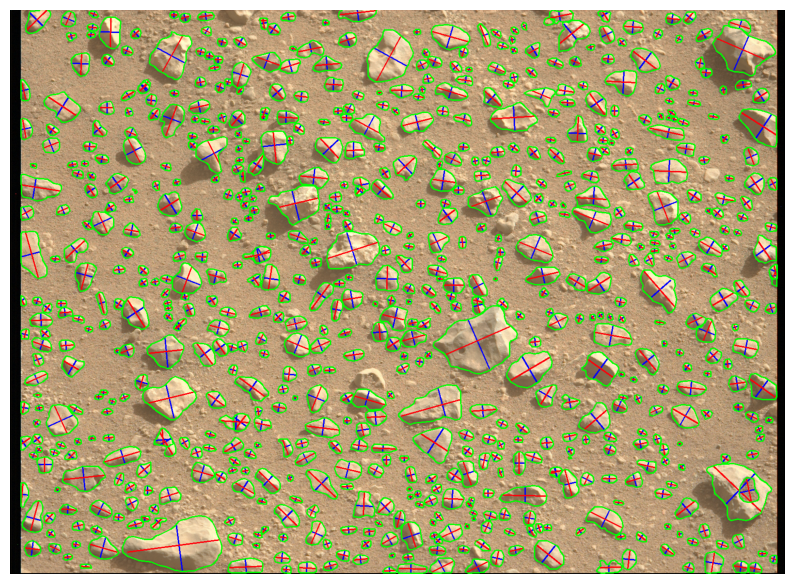

In [18]:
from shapely.geometry import LineString, Polygon
import matplotlib.pyplot as plt
import cv2
import numpy as np

plt.figure(figsize=(10, 10))

# Convert image to RGB for matplotlib display
img_rgb = img
plt.imshow(img_rgb)
plt.axis('off')

long_axes = []
short_axes = []
counted_areas = []
angles = []

for polygon in polygons:
    if len(polygon) < 5:
        continue
    
    # Flatten the polygon points
    flattened_polygon = [tuple(point[0]) for point in polygon]

    poly_pts = np.array(flattened_polygon, np.int32).reshape((-1, 1, 2))
    ellipse = cv2.fitEllipse(poly_pts)
    (center_x, center_y), (major_axis, minor_axis), angle = ellipse
    
    # Calculate the endpoints of the long and short axes
    angle_rad = np.radians(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)
    
    half_major_axis = major_axis / 2
    half_minor_axis = minor_axis / 2
    
    start_long = (center_x - cos_angle * half_major_axis, center_y - sin_angle * half_major_axis)
    end_long = (center_x + cos_angle * half_major_axis, center_y + sin_angle * half_major_axis)
    
    start_short = (center_x + sin_angle * half_minor_axis, center_y - cos_angle * half_minor_axis)
    end_short = (center_x - sin_angle * half_minor_axis, center_y + cos_angle * half_minor_axis)
    
    # Convert the polygon and lines to Shapely objects
    poly_shapely = Polygon(flattened_polygon)
    long_axis_line = LineString([start_long, end_long])
    short_axis_line = LineString([start_short, end_short])
    
    # Clip the lines to the polygon
    clipped_long_axis = long_axis_line.intersection(poly_shapely)
    clipped_short_axis = short_axis_line.intersection(poly_shapely)
    
    # Handle different intersection results for the long axis
    if isinstance(clipped_long_axis, LineString):
        clipped_long_axis_coords = [(int(x), int(y)) for x, y in clipped_long_axis.coords]
    else:
        continue

    # Handle different intersection results for the short axis
    if isinstance(clipped_short_axis, LineString):
        clipped_short_axis_coords = [(int(x), int(y)) for x, y in clipped_short_axis.coords]
    else:
        continue
    
    if clipped_long_axis_coords is None or clipped_short_axis_coords is None or len(clipped_long_axis_coords) != 2 or len(clipped_short_axis_coords) != 2:
        continue

    # seem to be flipped, TODO
    short_axes.append(clipped_long_axis.length)
    long_axes.append(clipped_short_axis.length)
    angles.append(angle)
    counted_areas.append(polygon_area(polygon))

    # Draw the axes on the image with a smaller line width
    cv2.line(img_rgb, clipped_long_axis_coords[0], clipped_long_axis_coords[1], (0, 0, 255), 2)  # Red for long axis
    cv2.line(img_rgb, clipped_short_axis_coords[0], clipped_short_axis_coords[1], (255, 0, 9), 2)  # Blue for short axis
    
    pts = np.array(polygon, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(img_rgb, [pts], True, (0, 255, 0), 2)  # Smaller line width for the border

# Redisplay the image with the additional annotations
plt.imshow(img_rgb)
plt.show()


## Convert from pixels to mm ##
Using line (vertical) FOV & focal distance from PDS XML file

In [19]:
import math

# FOV angle in degrees for the height
line_fov_deg = 4.63392

# Distance to the floor in mm
distance_to_floor = 2100.0

# Image height in pixels
image_height_pix = 1200

# Converting the FOV angle from degrees to radians
line_fov_rad = math.radians(line_fov_deg)

# Calculating the real-world height of the image
real_world_height = 2 * math.tan(line_fov_rad / 2) * distance_to_floor

# Calculating the height of one pixel
height_per_pixel = real_world_height / image_height_pix

# Printing the result
print(f"Height per pixel: {height_per_pixel:.6f} mm")

Height per pixel: 0.141612 mm


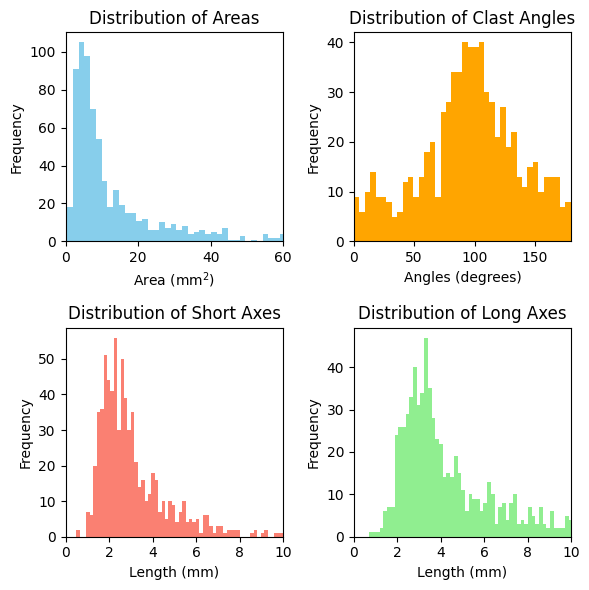

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the distribution of areas
real_areas = [np.round(area * (height_per_pixel ** 2), 4) for area in counted_areas]

# Plotting the distribution of long axes
real_longs = [long_axis * height_per_pixel for long_axis in long_axes]

# Plotting the distribution of short axes
real_shorts = [short_axis * height_per_pixel for short_axis in short_axes]

# Creating a 2x2 plot layout
plt.figure(figsize=(6, 6))

# Plotting the distribution of areas
plt.subplot(2, 2, 1)
plt.hist(real_areas, bins=200, color='skyblue')
plt.title('Distribution of Areas')
plt.xlabel('Area ($\mathrm{mm}^2$)')
plt.ylabel('Frequency')
plt.xlim(0, 60)

# Plotting the distribution of clast angles
plt.subplot(2, 2, 2)
plt.hist(angles, bins=40, color='orange')
plt.title('Distribution of Clast Angles')
plt.xlabel('Angles (degrees)')
plt.ylabel('Frequency')
plt.xlim(0, 180)

# Plotting the distribution of short axes
plt.subplot(2, 2, 3)
plt.hist(real_shorts, bins=100, color='salmon')
plt.title('Distribution of Short Axes')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.xlim(0, 10)


# Plotting the distribution of long axes
plt.subplot(2, 2, 4)
plt.hist(real_longs, bins=160, color='lightgreen')
plt.title('Distribution of Long Axes')
plt.xlabel('Length (mm)')
plt.ylabel('Frequency')
plt.xlim(0, 10)


plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# Create a DataFrame from the series
data = pd.DataFrame({'Areas': real_areas, 'Long Axes': real_longs, 'Short Axes': real_shorts, 'Angles': angles})

# Print summary statistics for all three
print(data.describe())


            Areas   Long Axes  Short Axes      Angles
count  716.000000  716.000000  716.000000  716.000000
mean    15.913959    4.622570    3.135694   95.815691
std     26.145633    2.891736    1.800992   40.730276
min      0.371000    0.679905    0.487264    0.024781
25%      4.452000    2.782097    1.969912   73.687786
50%      7.816050    3.630375    2.629331   97.384041
75%     16.757650    5.628631    3.715973  123.037874
max    317.886400   27.956081   16.198465  179.703903


/tmp/ipykernel_13004/3293160516.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
